<a href="https://colab.research.google.com/github/clarakl/UoA-GEOG761/blob/main/Landslide_susceptibility_ensemble_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extract patches

NO NEED TO RUN THIS IF YOU ALREADY HAVE THE DATASET

-------


How it works:

- Sentinel-2 SR provides L2A reflectance at 10 m.

- The .median() composite merges cloud-free pixels from 2019–2022.

- Each point.buffer(464 m) yields a ~928 m window around the coordinate.

- Patches are exported to Google Drive → “GEE_Landslide_Patches” folder.

In [ ]:
# Set up GEE API
import ee
ee.Authenticate()
ee.Initialize(project='clara-geog761-tryout-1')

Now, we will transform the numerical long-lat  into GEE points that are georeferenced. The cell after this visualizes these points.

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/GEOG761 Machine Learning for Remote Sensing/Group project landslide susceptibility/landslides_with_variables_fixed1.csv")

In [ ]:
# Convert to ee.FeatureCollection
def row_to_feature(row):
    geom = ee.Geometry.Point(float(row['Longitude']), float(row['Latitude']))
    # Make sure 'Valid Landslide' is integer and has no nulls for filtering
    label = row['Valid Landslide']
    if pd.notna(label):
        return ee.Feature(geom, {'id': int(row.name), 'label': int(label)})
    else:
      print("AAAAAAAAAAAAAA")
    return None

features = [row_to_feature(r) for _, r in df.iterrows()]
features = [f for f in features if f is not None] # Remove null features
fc = ee.FeatureCollection(features)

print("Feature collection created with", fc.size().getInfo(), "points.")

Feature collection created with 23852 points.


In [ ]:
import geemap

# Create an interactive map
Map = geemap.Map()

# Define visualization parameters (e.g., color the points red)
vis_params = {'color': 'red'}

# Add the FeatureCollection to the map
Map.addLayer(fc, vis_params, 'Landslide Points')

# Center the map view on your points with a zoom level of 8
Map.centerObject(fc, 8)

# Display the map
Map

Map(center=[-36.68817951291026, 174.66389329965313], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# Sentinel-2 Level-2A (Surface Reflectance)
collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterDate('2022-01-01', '2022-12-31')
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)))

median_image = collection.median().select(['B2','B3','B4','B8','B11','B12'])  # Blue, Green, Red, NIR

median_image = median_image.unmask(0)

Calculate area needed by taking the mean maximum area from all of the landslides

In [ ]:
import numpy as np

# Define patch size
df['Area Maximum'] = pd.to_numeric(df['Area Maximum'], errors='coerce')
patch_size_m = np.sqrt(df['Area Maximum'].mean(skipna=True) * 10_000)
half_width = patch_size_m / 2
print(f"Suggested patch width: {patch_size_m:.0f} meters")

Suggested patch width: 928 meters


In [ ]:
# Define the number of samples to take from each class
sample_size = 1250

# Filter the collection for each class
positives = fc.filter(ee.Filter.eq('label', 1)).limit(sample_size)
negatives = fc.filter(ee.Filter.eq('label', 0)).limit(sample_size)

# Merge the two limited collections into one
fc_limited = positives.merge(negatives)

# Shuffle the collection to mix the positive and negative samples
fc_limited = fc_limited.randomColumn()
fc_limited = fc_limited.sort('random')
print(f"Limited feature collection to {fc_limited.size().getInfo()} points.")

def create_and_tag_patch(feature):
    """Extracts a patch and sets its ID and label as properties."""

    # DEFINE THE APPROXIMATE AREA (in meters)
    patch_geometry = feature.geometry().buffer(half_width).bounds()

    # Store that area as metadata
    return median_image.set({
        'id': feature.get('id'),
        'label': feature.get('label'),
        'patch_geometry': patch_geometry
    })

tagged_image_patches = fc_limited.map(create_and_tag_patch)

print(f"Created a collection of {tagged_image_patches.size().getInfo()} tagged patches.")

Limited feature collection to 2500 points.
Created a collection of 2500 tagged patches.


In [ ]:
# Making sure that the patches have their labels

print("Labels of first 5 patches:", tagged_image_patches.limit(5).aggregate_array('label').getInfo())
print("Nr of negative and positive samples:", tagged_image_patches.aggregate_histogram('label').getInfo())

Labels of first 5 patches: [1, 0, 1, 1, 1]
Nr of negative and positive samples: {'0': 1250, '1': 1250}


Now we will create these patches in GEE.


In [ ]:
# GET THE SIZE (from the ImageCollection)
num_patches = tagged_image_patches.size().getInfo()

# BATCH-FETCH METADATA (from the ImageCollection)
print(f"Fetching metadata for {num_patches} patches...")

# Aggregate directly from the ImageCollection
all_ids_client = tagged_image_patches.aggregate_array('id').getInfo()
all_labels_client = tagged_image_patches.aggregate_array('label').getInfo()
all_geoms_client = tagged_image_patches.aggregate_array('patch_geometry').getInfo()

print("...Metadata fetched. Starting high-speed task submission.")

Fetching metadata for 2500 patches...
...Metadata fetched. Starting high-speed task submission.


In [ ]:
for i in range(num_patches):

    # Get metadata from your local Python lists
    patch_id = all_ids_client[i]
    patch_label = all_labels_client[i]
    patch_geom = all_geoms_client[i]


    # Assuming the geometry is a Polygon
    clean_geom = ee.Geometry.Polygon(patch_geom['coordinates'])

    # Create the filename
    filename = f"patch_id_{patch_id}_label_{patch_label}"

    # Define the export task
    task = ee.batch.Export.image.toDrive(
        image=median_image,
        description=f'Export_Patch_id_{patch_id}_index_{i}',
        folder='GEE_Landslide_Patches_2',
        fileNamePrefix=filename,
        region=clean_geom,
        dimensions='100x100',
        fileFormat='GeoTIFF'
    )


    if i%25 == 0:
      print(f"Exporting patch {i+1}/{num_patches}...")

    # Start the task
    task.start()

print(f"All {num_patches} tasks have been submitted.")
print("Monitor their progress in the 'Tasks' tab of the GEE Code Editor.")

Exporting patch 1/2500...
Exporting patch 26/2500...
Exporting patch 51/2500...
Exporting patch 76/2500...
Exporting patch 101/2500...
Exporting patch 126/2500...
Exporting patch 151/2500...
Exporting patch 176/2500...
Exporting patch 201/2500...
Exporting patch 226/2500...
Exporting patch 251/2500...
Exporting patch 276/2500...
Exporting patch 301/2500...
Exporting patch 326/2500...
Exporting patch 351/2500...
Exporting patch 376/2500...
Exporting patch 401/2500...
Exporting patch 426/2500...
Exporting patch 451/2500...
Exporting patch 476/2500...
Exporting patch 501/2500...
Exporting patch 526/2500...
Exporting patch 551/2500...
Exporting patch 576/2500...
Exporting patch 601/2500...
Exporting patch 626/2500...
Exporting patch 651/2500...
Exporting patch 676/2500...
Exporting patch 701/2500...
Exporting patch 726/2500...
Exporting patch 751/2500...
Exporting patch 776/2500...
Exporting patch 801/2500...
Exporting patch 826/2500...
Exporting patch 851/2500...
Exporting patch 876/2500.

In [ ]:
# Visualizing one patch

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

filepath = '/content/drive/MyDrive/GEE_Landslide_Patches/patch_id_1171_label_1.tif'

with rasterio.open(filepath) as src:
    # Read the red, green, and blue bands into a 3D array
    # Note: Sentinel-2 band numbers might be different, e.g., B4, B3, B2 are often bands 4, 3, 2.
    # We'll assume the first three bands are the ones we want for simplicity here.
    # You may need to adjust the numbers in read([1, 2, 3])
    rgb = src.read([1, 2, 3])

    # Function to normalize bands for display
    def normalize(array):
        array_min, array_max = array.min(), array.max()
        return ((array - array_min) / (array_max - array_min))

    # Normalize each band to the 0-1 range for proper RGB display
    red_normalized = normalize(rgb[0])
    green_normalized = normalize(rgb[1])
    blue_normalized = normalize(rgb[2])

    # Stack the bands back together
    rgb_normalized = np.dstack((red_normalized, green_normalized, blue_normalized))

    # Display the true-color image
    plt.imshow(rgb_normalized)
    plt.show()

--------
# The next two big portions is just me playing around and understanding what the fuck I have to do. For the actual ensemble model jump to "Ensemble model: Random Forest - CNN"

### (I suggest collapsing the titles "CNN" and "Now we try to give our brain a body" in order not having to scroll too much)
----

# CNN

## Step 1: Access data in google drive

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 59.6 MB/s eta 0:00:00


In [136]:
import os
import glob
import rasterio
import numpy as np

folder_path = '/content/drive/MyDrive/GEE_Landslide_Patches_2'

file_pattern = os.path.join(folder_path, "*.tif")
patch_files = glob.glob(file_pattern)

print(f"Found {len(patch_files)} patch files.")
if patch_files:
    print(f"Example file: {patch_files[0]}")

Found 398 patch files.
Example file: /content/drive/MyDrive/GEE_Landslide_Patches_2/patch_id_89_label_1.tif


Now we'll create the training data by assigning the image data of each tiff file to our X and the label (which is found in the end of each patch's name, e.g., 'patch_id_123_label_1.tif') to our y.

In [137]:
X_data = []  # features
y_data = []  # targets
skipped_count = 0

with rasterio.open(patch_files[5]) as src:
    target_shape = src.read().shape
print(f"All patches will be validated against this shape: {target_shape}")

for file_path in patch_files:
  try:
    # --- Read the image data ---
    with rasterio.open(file_path) as src:
        image_data = src.read()

    # --- FIX 2: Check if this patch matches the target shape ---
    if image_data.shape == target_shape:
        X_data.append(image_data)

        # --- Get the label (only if the data is added) ---
        filename = os.path.basename(file_path)
        label_str = filename.split('_label_')[1].split('.tif')[0]
        y_data.append(int(label_str))
    else:
        # Skip this file as its shape is different
        print(f"Skipping {file_path}: Shape was {image_data.shape}, expected {target_shape}")
        skipped_count += 1

  except Exception as e:
    print(f"Error reading {file_path}: {e}")
    skipped_count += 1

# Convert the lists into NumPy arrays for machine learning
X_train = np.array(X_data)
y_train = np.array(y_data)

print(f"\nSuccessfully loaded {len(X_train)} patches.")
print(f"Skipped {skipped_count} patches due to shape mismatch or errors.")
print(f"Loaded X_train data with shape: {X_train.shape}")
print(f"Loaded y_train data with shape: {y_train.shape}")

All patches will be validated against this shape: (6, 100, 100)

Successfully loaded 398 patches.
Skipped 0 patches due to shape mismatch or errors.
Loaded X_train data with shape: (398, 6, 100, 100)
Loaded y_train data with shape: (398,)


In [ ]:
y_train

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0])

In [138]:
# Creating train and test data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (318, 6, 100, 100)
y_train shape: (318,)
X_test shape: (80, 6, 100, 100)
y_test shape: (80,)


In [139]:
# prepare the data for the CNN

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Your data shape is (samples, bands, height, width), e.g., (2000, 6, 100, 100)
# Keras's default format is (samples, height, width, bands)
# We need to re-order the dimensions.

print(f"Original X_train shape: {X_train.shape}")
X_train_reshaped = np.transpose(X_train, (0, 2, 3, 1))
X_test_reshaped = np.transpose(X_test, (0, 2, 3, 1))
print(f"Reshaped X_train shape: {X_train_reshaped.shape}")

# Normalize pixel values to be between 0 and 1
# This is crucial for neural network performance
max_pixel_value = np.max(X_train_reshaped)
print(f"Max pixel value found: {max_pixel_value}")

X_train_norm = X_train_reshaped.astype('float32') / max_pixel_value
X_test_norm = X_test_reshaped.astype('float32') / max_pixel_value

# Get the input shape for the model (height, width, bands)
input_shape = X_train_norm.shape[1:]
print(f"Model input shape will be: {input_shape}")

Original X_train shape: (318, 6, 100, 100)
Reshaped X_train shape: (318, 100, 100, 6)
Max pixel value found: 8704.0
Model input shape will be: (100, 100, 6)


In [140]:
# Build the CNN

model = keras.Sequential([
    # Input Layer
    keras.Input(shape=input_shape),

    # Convolutional Block 1
    # 32 filters, 3x3 kernel size
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    # 64 filters, 3x3 kernel size
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Classifier Head
    layers.Flatten(), # Flattens the 3D map to a 1D vector
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5), # Helps prevent overfitting

    # Output Layer
    # 1 neuron with 'sigmoid' activation for a 0-to-1 probability
    layers.Dense(1, activation="sigmoid")
])

In [141]:
# Compiling the model

from tensorflow.keras.optimizers import Adam

# FIX: Use a much smaller learning rate to prevent 'nan'
optimizer = Adam(learning_rate=0.0001)  # Default is 0.001

# We use 'binary_crossentropy' because this is a 2-class (0 or 1) problem
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

# Print a summary of the model
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 98, 98, 32)     │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │     2,166,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,187,169 (8.34 MB)

 Trainable params: 2,187,169 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

In [142]:
# Training the model

print("\nStarting model training...")
history = model.fit(
    X_train_norm,          # Use normalized, reshaped training data
    y_train,               # Training labels
    batch_size=32,
    epochs=15,             # You can increase this if needed
    validation_split=0.2
)

print("Training finished.")


Starting model training...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 723ms/step - accuracy: 0.6213 - loss: 0.6498 - val_accuracy: 0.9219 - val_loss: 0.5168
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - accuracy: 0.9137 - loss: 0.4970 - val_accuracy: 0.9375 - val_loss: 0.3586
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 575ms/step - accuracy: 0.9141 - loss: 0.3700 - val_accuracy: 0.9531 - val_loss: 0.2623
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 594ms/step - accuracy: 0.8777 - loss: 0.3435 - val_accuracy: 0.9375 - val_loss: 0.2209
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 468ms/step - accuracy: 0.9006 - loss: 0.2752 - val_accuracy: 0.9531 - val_loss: 0.2002
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 539ms/step - accuracy: 0.8793 - loss: 0.2941 - val_accuracy: 0.9219 - val_loss: 0.1879
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 556ms/step - accuracy: 0.9211 - loss: 0.2100 - val_accuracy: 0.9531 - val_loss: 0.1812
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 472ms/step - accuracy: 0.9030 - loss: 0.2505 - val

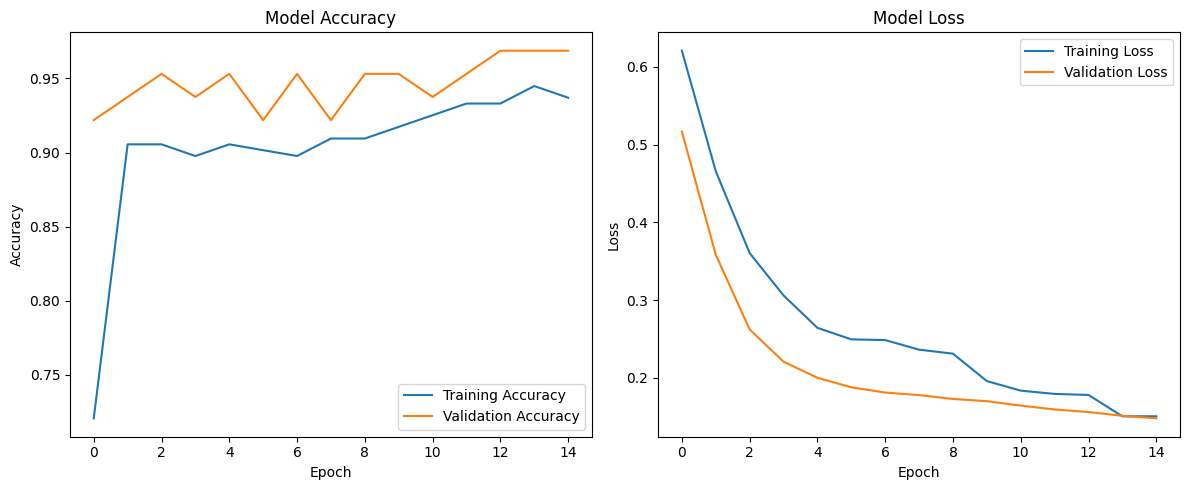

In [143]:
import matplotlib.pyplot as plt

# --- 1. Plot Training & Validation Accuracy ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # (1 row, 2 columns, plot 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# --- 2. Plot Training & Validation Loss ---
plt.subplot(1, 2, 2) # (1 row, 2 columns, plot 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# --- 3. Show the plots ---
plt.tight_layout() # Adjusts plots to prevent overlap
plt.show()

In [144]:
import numpy as np
from sklearn.metrics import classification_report

# --- 1. Get the model's predictions for the entire test set ---
# The output is a list of raw probabilities (e.g., 0.05, 0.92, etc.)
y_pred_proba = model.predict(X_test_norm)

print("--- Evaluating Model on Unseen Test Data ---\n")
print(f"Displaying predictions for the first 20 patches:\n")

# --- 2. Loop through a sample of predictions and display them ---
for i in range(min(20, len(y_test))): # Show up to 20 predictions

    # Get the raw probability from the model's output
    probability = y_pred_proba[i][0]

    # Convert to a percentage
    susceptibility_percent = probability * 100

    # Get the actual, correct label
    actual_label = y_test[i]

    # Print a clear, formatted result
    print(f"Patch {i+1}: Susceptibility = {susceptibility_percent:.2f}%  (Actual Label: {actual_label})")


# --- 3. Get the final, overall accuracy on the test set ---
final_loss, final_accuracy = model.evaluate(X_test_norm, y_test, verbose=0)
print(f"\n-------------------------------------------------")
print(f"Final Model Accuracy on Test Set: {final_accuracy * 100:.2f}%")
print(f"-------------------------------------------------")


# --- 4. (Optional) Show a more detailed performance report ---
# We convert probabilities to binary predictions (0 or 1) using a 0.5 threshold
y_pred_binary = (y_pred_proba > 0.5).astype(int)

print("\nDetailed Classification Report:\n")
# This shows precision, recall, and f1-score for both classes (0 and 1)
print(classification_report(y_test, y_pred_binary, target_names=['No Landslide (0)', 'Landslide (1)']))

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step
--- Evaluating Model on Unseen Test Data ---

Displaying predictions for the first 20 patches:

Patch 1: Susceptibility = 93.41%  (Actual Label: 1)
Patch 2: Susceptibility = 20.13%  (Actual Label: 0)
Patch 3: Susceptibility = 11.37%  (Actual Label: 0)
Patch 4: Susceptibility = 99.89%  (Actual Label: 1)
Patch 5: Susceptibility = 98.42%  (Actual Label: 1)
Patch 6: Susceptibility = 18.41%  (Actual Label: 0)
Patch 7: Susceptibility = 99.87%  (Actual Label: 1)
Patch 8: Susceptibility = 99.85%  (Actual Label: 1)
Patch 9: Susceptibility = 7.81%  (Actual Label: 0)
Patch 10: Susceptibility = 0.02%  (Actual Label: 0)
Patch 11: Susceptibility = 88.21%  (Actual Label: 1)
Patch 12: Susceptibility = 99.61%  (Actual Label: 1)
Patch 13: Susceptibility = 82.04%  (Actual Label: 1)
Patch 14: Susceptibility = 99.15%  (Actual Label: 1)
Patch 15: Susceptibility = 8.84%  (Actual Label: 0)
Patch 16: Susceptibility = 99.71%  (Actual Label: 1)
Patch 17: Susceptibility = 5.

# Now we try to give our brain a body

In [145]:
# Save model
model.save('landslide_susceptibility_model.keras')

The following code takes in a really small patch, just like the ones in our dataset, and makes a prediction. I will later create code that caan take in a larger area and make a susceptibility map out of it. This larger image needs to have the exaact same bands, needs to be noralized the exact same way, the only thing that can ddiffer is the overall size, i.e. it could be 5000x5000 instead of 1000x1000 like our patches.

Loading model...
Loading patch: /content/drive/MyDrive/GEE_Landslide_Patches_2/patch_id_913_label_1.tif
Model Prediction: 53.00% Susceptible


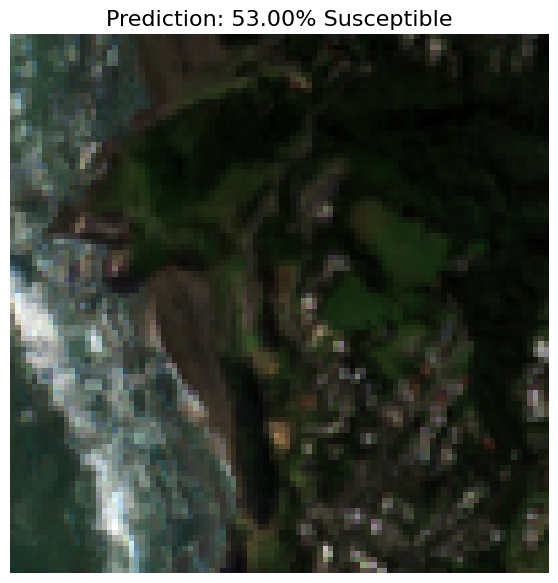

In [ ]:
import tensorflow as tf
from tensorflow import keras
import rasterio
import numpy as np
import matplotlib.pyplot as plt # <-- Make sure this is imported

# --- 1. CONFIGURATION ---
MODEL_FILE = 'landslide_susceptibility_model.keras'
PATCH_FILE = '/content/drive/MyDrive/GEE_Landslide_Patches_2/patch_id_913_label_1.tif'

# --- You MUST get this value from your training script ---
MAX_PIXEL_VALUE = 8704.0

PATCH_SIZE = 100

# --- 2. LOAD MODEL ---
print("Loading model...")
model = keras.models.load_model(MODEL_FILE)

print(f"Loading patch: {PATCH_FILE}")
with rasterio.open(PATCH_FILE) as src:
    # Read all band data
    patch_data = src.read() # Shape (bands, 100, 100)

    # Check if patch is the correct size
    if patch_data.shape[1] != PATCH_SIZE or patch_data.shape[2] != PATCH_SIZE:
        print(f"Error: Patch is not {PATCH_SIZE}x{PATCH_SIZE}. Shape: {patch_data.shape}")
    else:

        # --- 3. PRE-PROCESS THE PATCH (for the model) ---

        # (bands, h, w) -> (h, w, bands)
        patch_transposed = np.transpose(patch_data, (1, 2, 0))
        # Normalize
        patch_norm = patch_transposed.astype('float32') / MAX_PIXEL_VALUE
        # Add batch dimension: (h, w, bands) -> (1, h, w, bands)
        patch_batch = np.expand_dims(patch_norm, axis=0)

        # --- 4. PREDICT ---
        # Get the raw probability (0.0 to 1.0)
        probability = model.predict(patch_batch, verbose=0)[0][0]
        susceptibility_percent = probability * 100

        print(f"Model Prediction: {susceptibility_percent:.2f}% Susceptible")

        # --- 5. VISUALIZE THE PATCH (True Color) ---

        # Helper function to normalize bands for 0-1 display
        def normalize(array):
            array_min, array_max = np.nanmin(array), np.nanmax(array)
            return ((array - array_min) / (array_max - array_min))

        # Normalize the first 3 bands (assuming Blue, Green, Red)
        blue_norm = normalize(patch_data[0])
        green_norm = normalize(patch_data[1])
        red_norm = normalize(patch_data[2])

        # Stack for plotting: (h, w, channels)
        rgb_image = np.dstack((red_norm, green_norm, blue_norm))

        # --- 6. PLOT THE IMAGE WITH THE PREDICTION ---
        plt.figure(figsize=(7, 7))
        plt.imshow(rgb_image)
        plt.title(f"Prediction: {susceptibility_percent:.2f}% Susceptible", fontsize=16)
        plt.axis('off')
        plt.show()

The following is the code for the susceptibility map, I did not yet try it out on a larger area.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import rasterio
import numpy as np
import math

# --- 1. CONFIGURATION ---
MODEL_FILE = 'landslide_susceptibility_model.keras'
NEW_IMAGE_FILE = '/content/drive/MyDrive/GEE_Landslide_Patches_2/patch_id_913_label_1.tif'
OUTPUT_MAP_FILE = 'susceptibility_map.tif'

# --- You MUST get this value from your training script ---
# This is the max value you used to normalize your data
MAX_PIXEL_VALUE = 8704.0  # Example value, REPLACE THIS

PATCH_SIZE = 100

# --- 2. LOAD MODEL AND DATA ---
print("Loading model...")
model = keras.models.load_model(MODEL_FILE)

print(f"Loading new image: {NEW_IMAGE_FILE}")
with rasterio.open(NEW_IMAGE_FILE) as src:
    # Read all band data
    image_data = src.read()
    # Get the geospatial metadata
    profile = src.profile

    # Create an empty array to store the susceptibility "heat map"
    # We use float32 to store probabilities (e.g., 0.92)
    susceptibility_map = np.zeros((src.height, src.width), dtype='float32')

    print("Running susceptibility scan...")
    # --- 3. "SLIDING WINDOW" PREDICTION ---
    # We loop over the image in 100x100 blocks

    # Calculate how many steps we need in each direction
    steps_y = math.ceil(src.height / PATCH_SIZE)
    steps_x = math.ceil(src.width / PATCH_SIZE)

    for y in range(steps_y):
        for x in range(steps_x):
            # Define the window
            y_start = y * PATCH_SIZE
            x_start = x * PATCH_SIZE

            # Ensure the patch doesn't go out of bounds
            y_end = min(y_start + PATCH_SIZE, src.height)
            x_end = min(x_start + PATCH_SIZE, src.width)

            # Extract the patch
            patch = image_data[:, y_start:y_end, x_start:x_end]

            # Skip if patch is not the full 100x100 size (e.g., at the image edge)
            if patch.shape[1] != PATCH_SIZE or patch.shape[2] != PATCH_SIZE:
                continue

            # --- 4. PRE-PROCESS THE PATCH (CRITICAL) ---
            # This must exactly match your training code

            # (bands, h, w) -> (h, w, bands)
            patch_transposed = np.transpose(patch, (1, 2, 0))
            # Normalize
            patch_norm = patch_transposed.astype('float32') / MAX_PIXEL_VALUE
            # Add batch dimension: (h, w, bands) -> (1, h, w, bands)
            patch_batch = np.expand_dims(patch_norm, axis=0)

            # --- 5. PREDICT ---
            # Get the raw probability (0.0 to 1.0)
            probability = model.predict(patch_batch, verbose=0)[0][0]

            # --- 6. FILL THE MAP ---
            # "Paint" this probability onto the output map
            susceptibility_map[y_start:y_end, x_start:x_end] = probability

    print("Scan complete. Saving map...")

# --- 7. SAVE THE FINAL "HEAT MAP" ---
# We update the metadata to save a 1-band (float) image
profile.update(
    dtype='float32',
    count=1,  # We are saving 1 band (the probability)
    driver='GTiff'
)

with rasterio.open(OUTPUT_MAP_FILE, 'w', **profile) as dst:
    dst.write(susceptibility_map, 1) # Write the map to the first band

print(f"Success! Susceptibility map saved to: {OUTPUT_MAP_FILE}")

Loading model...
Loading new image: /content/drive/MyDrive/GEE_Landslide_Patches_2/patch_id_913_label_1.tif
Running susceptibility scan...
Scan complete. Saving map...
Success! Susceptibility map saved to: susceptibility_map.tif


Loading map: susceptibility_map.tif
Displaying map...


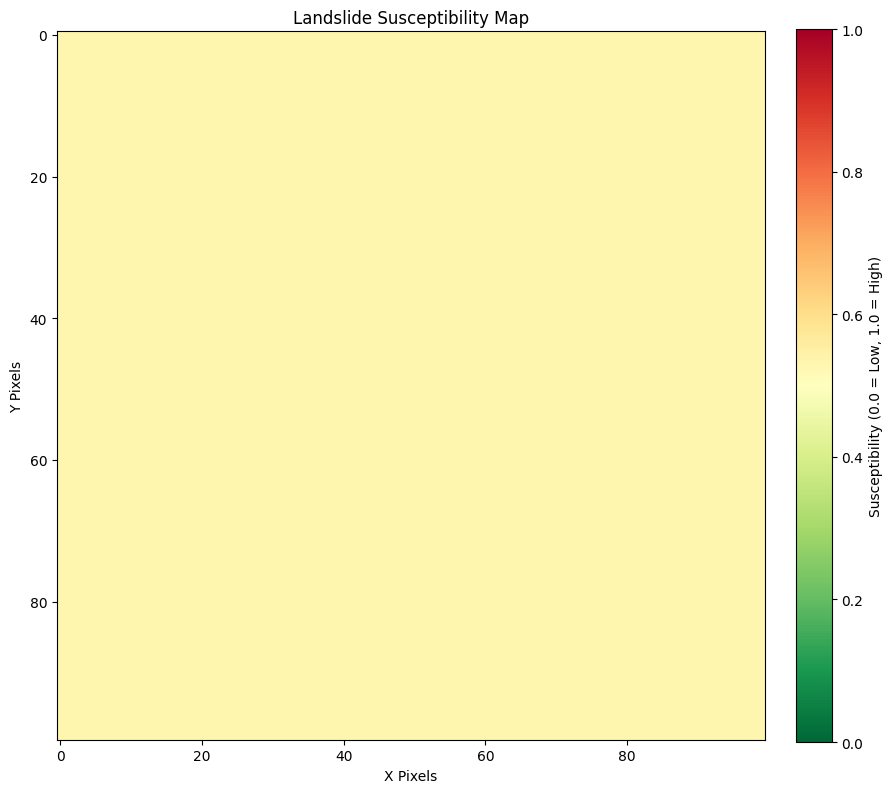

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

OUTPUT_MAP_FILE = 'susceptibility_map.tif'

print(f"Loading map: {OUTPUT_MAP_FILE}")

with rasterio.open(OUTPUT_MAP_FILE) as src:
    # Read the first (and only) band
    susceptibility_data = src.read(1)

    # Replace 0 values (no data/padding) with 'nan' so they are transparent
    susceptibility_data[susceptibility_data == 0] = np.nan

    print("Displaying map...")

    plt.figure(figsize=(10, 10))

    # Use 'imshow' to display the 2D array as an image
    # We use a color map ('RdYlGn_r') where Red = High, Green = Low
    img = plt.imshow(susceptibility_data, cmap='RdYlGn_r',
                     vmin=0.0, vmax=1.0)

    plt.title("Landslide Susceptibility Map")
    plt.xlabel("X Pixels")
    plt.ylabel("Y Pixels")

    # Add a color bar to show what the values mean
    cbar = plt.colorbar(img, fraction=0.046, pad=0.04)
    cbar.set_label('Susceptibility (0.0 = Low, 1.0 = High)')

    plt.show()

# Ensemble model: Random forest - CNN
This part of the code creates a multi-modal model that is able to take in patches and numerical data like slop, landcover etc.

1. Loading the data

This code loads two types of data: .tif files which are patches created around the long-lat points in our numerical datasets, and some geological and topographical data for each point. In the end, we align these two types of data to be able to feed it into the model. We create the following data:
- X_images_list: All the pixel data from the patches.

- X_numerical_list: All the corresponding numerical features (slope, curvature, etc.) from the CSV.

- y_labels_list: The labels (0 or 1) that align with both.

Then we convert these lists into numpy arrays and normalize them for the machine learning model by transposing them to (samples, h, w, bands) and dividing them by MAX_PIXEL_VALUE.

In the end, we create the train-test split already.

In [150]:
import pandas as pd
import glob
import rasterio
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the Numerical Data
csv_path = '/content/drive/MyDrive/GEOG761 Machine Learning for Remote Sensing/Group project landslide susceptibility/landslides_with_variables_fixed1.csv'
df = pd.read_csv(csv_path)

# Load Image Patches and Align
folder_path = '/content/drive/MyDrive/GEE_Landslide_Patches_2'
patch_files = glob.glob(folder_path + "/*.tif")

X_images_list = []
X_numerical_list = []
y_labels_list = []

print(f"Found {len(patch_files)} files. Aligning with CSV...")

for file_path in patch_files:
    filename = os.path.basename(file_path)

    #  Extract ID and Label from filename
    # e.g., 'patch_id_89_label_1.tif'
    parts = filename.split('_')
    patch_id = int(parts[2]) # Get the '89'
    patch_label = int(parts[4].split('.tif')[0]) # Get the '1'

    # Find the matching row in the CSV
    row = df[df['ID'] == patch_id]

    if not row.empty:
        # Add the numerical data
        numerical_features = row[['CURVATURE', 'TWI', 'SLOPE_deg', 'DEM', 'LANDCOVER_CODE', 'ASPECT_sin', 'ASPECT_cos']].values[0]
        X_numerical_list.append(numerical_features)

        # Add the label
        y_labels_list.append(patch_label)

        # Add the image data
        with rasterio.open(file_path) as src:
            X_images_list.append(src.read())

# Convert to NumPy Arrays
X_images = np.array(X_images_list)
X_numerical = np.array(X_numerical_list)
y = np.array(y_labels_list)

# -- Pre-process --
# Images: Transpose and normalize as before
X_images_norm = np.transpose(X_images, (0, 2, 3, 1)) / MAX_PIXEL_VALUE

# Numerical: Scale the data
# This scales numbers (like slope) to be in a similar range (e.g., -1 to 1)
scaler = StandardScaler()
X_numerical_norm = scaler.fit_transform(X_numerical)

print(f"Image data shape: {X_images_norm.shape}")
print(f"Numerical data shape: {X_numerical_norm.shape}")
print(f"Label data shape: {y.shape}")

# Split all three datasets together
# We need to split twice to explicitely define the validation set because a random forest model,
# as opposed to a CNN, does not have a built-in validation split

# First split: (Train + Val) and Test (80% / 20%)
X_img_train_val, X_img_test, y_train_val, y_test = train_test_split(
    X_images_norm, y, test_size=0.2, random_state=42, stratify=y
)
X_num_train_val, X_num_test, _, _ = train_test_split(
    X_numerical_norm, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: (Train) and (Val) (75% of 80% = 60% / 25% of 80% = 20%)
X_img_train, X_img_val, y_train, y_val = train_test_split(
    X_img_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)
X_num_train, X_num_val, _, _ = train_test_split(
    X_num_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Train shapes: {X_img_train.shape}, {X_num_train.shape}, {y_train.shape}")
print(f"Val shapes:   {X_img_val.shape}, {X_num_val.shape}, {y_val.shape}")
print(f"Test shapes:  {X_img_test.shape}, {X_num_test.shape}, {y_test.shape}")

Found 465 files. Aligning with CSV...
Image data shape: (465, 100, 100, 6)
Numerical data shape: (465, 7)
Label data shape: (465,)
Train shapes: (279, 100, 100, 6), (279, 7), (279,)
Val shapes:   (93, 100, 100, 6), (93, 7), (93,)
Test shapes:  (93, 100, 100, 6), (93, 7), (93,)


Now we build and train the CNN first.

In [151]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_input_shape = X_img_train.shape[1:]
input_image = keras.Input(shape=image_input_shape)
cnn_branch = layers.Conv2D(32, (3, 3), activation='relu')(input_image)
cnn_branch = layers.MaxPooling2D((2, 2))(cnn_branch)
cnn_branch = layers.Conv2D(64, (3, 3), activation='relu')(cnn_branch)
cnn_branch = layers.MaxPooling2D((2, 2))(cnn_branch)
cnn_branch = layers.Flatten()(cnn_branch)
cnn_branch = layers.Dense(64, activation='relu')(cnn_branch)
cnn_output = layers.Dense(1, activation='sigmoid')(cnn_branch)

cnn_model = keras.Model(inputs=input_image, outputs=cnn_output)

cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n--- Training CNN Model ---")
cnn_model.fit(
    X_img_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_img_val, y_val)
)


--- Training CNN Model ---
Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 536ms/step - accuracy: 0.5589 - loss: 0.6640 - val_accuracy: 0.8925 - val_loss: 0.5474
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 746ms/step - accuracy: 0.8587 - loss: 0.5110 - val_accuracy: 0.9355 - val_loss: 0.3964
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 646ms/step - accuracy: 0.9139 - loss: 0.3767 - val_accuracy: 0.9247 - val_loss: 0.2882
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - accuracy: 0.9127 - loss: 0.2968 - val_accuracy: 0.9355 - val_loss: 0.2255
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 929ms/step - accuracy: 0.9128 - loss: 0.2213 - val_accuracy: 0.9355 - val_loss: 0.1950
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 666ms/step - accuracy: 0.8852 - loss: 0.2551 - val_accuracy: 0.9355 - val_loss: 0.1866
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 462ms/step - accuracy: 0.9038 - loss: 0.2409 - val_accuracy: 0.9355 - val_loss: 0.1761
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 584ms/step - accuracy: 0.9356 - loss: 0.1748 - val_

Now the simple random forest.

In [152]:
from sklearn.ensemble import RandomForestClassifier

print("\n--- Training Random Forest Model ---")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_num_train, y_train)

# Check validation accuracy
val_accuracy = rf_model.score(X_num_train, y_train)
print(f"Random Forest Validation Accuracy: {val_accuracy:.4f}")


--- Training Random Forest Model ---
Random Forest Validation Accuracy: 0.9964


## Ensemble model combined by logistic regression

In the next step, we will stack both of the models. We will use the validation set to train a *new* very simple model (I chose logistic regression, it just needs to learn how to best combine the predictions from the two base models). The logistic regression model learns how much to trust each base model's prediction.

It looks like this:

It gets the inputs from both models:

- The CNN: "Based on the image, I'm 90% sure this is a landslide."

- The Random Forest: "Based on the numbers, I'm only 60% sure."

The logistic regression model's job is to take those two inputs (90% and 60%) and make the final decision. By training it on the validation data, it learns which model is more reliable in which situations.

For example, it might learn: "The CNN is usually overconfident, so I'll trust the Random Forest more." Or it might learn: "When both models agree, they are almost always right, but when they disagree, I should trust the CNN."

It learns the optimal weights or rules to combine the two predictions into a single, more accurate final prediction.

In [153]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Get predictions from base models on the VALIDATION set
print("\n--- Training Meta-Model ---")
cnn_val_probs = cnn_model.predict(X_img_val)
rf_val_probs = rf_model.predict_proba(X_num_val)[:, 1] # Get prob of class '1'

# 2. Stack these predictions into a new feature array
# Shape will be (num_val_samples, 2)
X_val_stacked = np.c_[cnn_val_probs, rf_val_probs]

# 3. Train the meta-model (Logistic Regression is perfect for this)
# It learns the best "weight" for the CNN prob vs. the RF prob
meta_model = LogisticRegression()
meta_model.fit(X_val_stacked, y_val)

print("Meta-Model trained.")


--- Training Meta-Model ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
Meta-Model trained.


And finally, we will evaluate the final hybrid model on the test set.

In [154]:
# 1. Get predictions from base models on the TEST set
print("\n--- Final Evaluation on Test Set ---")
cnn_test_probs = cnn_model.predict(X_img_test)
rf_test_probs = rf_model.predict_proba(X_num_test)[:, 1]

# 2. Stack them just like before
X_test_stacked = np.c_[cnn_test_probs, rf_test_probs]

# 3. Get the final hybrid prediction from the meta-model
hybrid_predictions = meta_model.predict(X_test_stacked)

# 4. Report the results
final_accuracy = accuracy_score(y_test, hybrid_predictions)
print(f"\nFinal HYBRID Model Accuracy: {final_accuracy * 100:.2f}%")
print("\nHybrid Model Classification Report:")
print(classification_report(y_test, hybrid_predictions))


--- Final Evaluation on Test Set ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step

Final HYBRID Model Accuracy: 96.77%

Hybrid Model Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        44
           1       0.98      0.96      0.97        49

    accuracy                           0.97        93
   macro avg       0.97      0.97      0.97        93
weighted avg       0.97      0.97      0.97        93

